# TM10007 Assignment template

In [1]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [0]:
# General packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn import svm
from sklearn import preprocessing
import numpy as np
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.utils.fixes import loguniform


# Data loading and cleaning

Some functions

In [0]:
# Some functions we will use
from sklearn.decomposition import PCA

def colorplot(clf, ax, x, y, h=100):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm



Data loading and handling missing data. 

In [60]:
# Data loading functions. 
from adni.load_data import load_data 

data = load_data()
print(data.head())
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')
#data_missing = data.isnull()
#print(data_missing.index[data_missing == True])

# Creating vector of labels
data_no_label = data.drop(columns='label')
print(f'The number of features: {len(data_no_label.columns)}')
x = data_no_label
y = data['label']

# Split data
X_train, X_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2)

def removezeros(X):
   X_nozeros = X.loc[:, (X != 0).any(axis=0)]
   return X_nozeros

X_train_df = removezeros(X_train)
X_test_df = removezeros(X_test)
print(f'The number of samples: {len(X_train_df.index)}')
print(f'The number of columns: {len(X_train_df.columns)}')
X_train = X_train_df.values
X_test = X_test_df.values

x_nan = np.isnan(X_train)
print(f'The number of found NaN is: {np.sum(x_nan)}')
#x_zero = np.where(X_train == 0)[0]
#print(f'The number of found zeros is: {len(x_zero)}')

                     hf_energy  ...  vf_Frangi_inner_std_SR(1.0, 10.0)_SS2.0
ID                              ...                                         
0_002_S_0413_bl_0  5403.229408  ...                             4.207831e-10
0_002_S_0559_bl_0   922.459760  ...                             3.137258e-10
0_002_S_0619_bl_0  1674.765276  ...                             4.219847e-10
0_002_S_0685_bl_0  3443.797200  ...                             5.954654e-11
0_002_S_0816_bl_0   914.469846  ...                             4.174750e-10

[5 rows x 268 columns]
The number of samples: 855
The number of columns: 268
The number of features: 267
The number of samples: 684
The number of columns: 263
The number of found NaN is: 0


# Feature scaling and selection


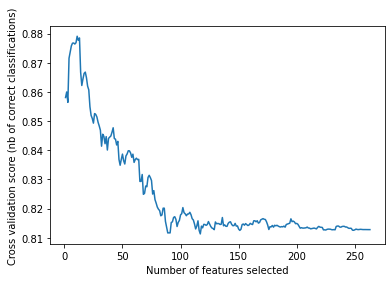

Optimal number of features : 11


In [44]:
# Scaling of features
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
#forest = RandomForestClassifier(n_estimators=100)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(2),
              scoring='roc_auc')
select = rfecv.fit(X_train_scaled, y_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Optimal number of features : %d" % rfecv.n_features_)

In [63]:
# Get new X_train with only important features 
features = X_train_df * select.support_
x_train_df = removezeros(features)
x_train = x_train_df.values


Index(['hf_entropy', 'hf_peak', 'logf_peak_sigma5',
       'phasef_phasesym_quartile_range_WL3_N5', 'tf_GLRLM_RunPercentage',
       'tf_Gabor_0.05A2.36std', 'tf_Gabor_0.2A0.79kurt',
       'tf_Gabor_0.2A0.79min', 'tf_Gabor_0.2A2.36kurt', 'tf_LBP_std_R3_P12',
       'tf_NGTDM_Complexity'],
      dtype='object')


In [0]:
 # Train Classifier  
# defining parameter range 
param_grid = {'C': loguniform(1e0, 1e3), 
              'gamma': loguniform(1e-4, 1e0), 
              'kernel': ['rbf','poly', 'linear']}  
  
grid = RandomizedSearchCV(SVC(), param_grid, n_iter=20, refit = True, verbose = 3, random_state=42) 
  
# fitting the model for grid search 
grid.fit(x_train, y_train)

print("The best classifier is: ", grid.best_estimator_)



Fitting 5 folds for each of 20 candidates, totalling 100 fitsERROR! Session/line number was not unique in 
database. History logging moved to new session 61
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.869, total=  18.8s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.8s remaining:    0.0s


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.781, total= 1.2min
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.5min remaining:    0.0s


[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.781, total=  24.2s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...
[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.803, total=  14.1s
[CV] C=13.292918943162162, gamma=0.6351221010640693, kernel=linear ...
[CV]  C=13.292918943162162, gamma=0.6351221010640693, kernel=linear, score=0.860, total= 1.3min
[CV] C=218.3096839052459, gamma=0.02440060709081752, kernel=poly .....
